# 1. Load index

In [1]:
import genomics_data_index

print(genomics_data_index.__version__)

0.5.0


In [2]:
import genomics_data_index.api as gdi

db = gdi.GenomicsDataIndex.connect('cases/full/index')
db

<GenomicsDataIndex(samples=85)>

# 2. Load metadata

In [3]:
import pandas as pd

metadata_df = pd.read_csv('metadata.tsv', sep='\t')
metadata_df['cluster'] = metadata_df['outbreak']
metadata_df.loc[metadata_df['cluster'] == 'outgroup', 'cluster'] = pd.NA
metadata_df

,dataSetName,strain,outbreak,SRArun_acc,reference,cluster
0,0810PADBR-1,D5663,outgroup_0810PADBR-1,SRR1999649,GCA_001879185.2_ASM187918v2_genomic,outgroup_0810PADBR-1
1,0810PADBR-1,D7321,0810PADBR-1,SRR3215135,GCA_001879185.2_ASM187918v2_genomic,0810PADBR-1
2,0810PADBR-1,D7331,0810PADBR-1,SRR3214715,GCA_001879185.2_ASM187918v2_genomic,0810PADBR-1
3,0810PADBR-1,D7319,0810PADBR-1,SRR3215210,GCA_001879185.2_ASM187918v2_genomic,0810PADBR-1
4,0810PADBR-1,D7323,0810PADBR-1,SRR3215124,GCA_001879185.2_ASM187918v2_genomic,0810PADBR-1
...,...,...,...,...,...,...
80,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN000970,1203NYJAP-1,SRR498444,GCF_000439415.1_ASM43941v1_genomic,1203NYJAP-1
81,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN001112,1203NYJAP-1,SRR1258439,GCF_000439415.1_ASM43941v1_genomic,1203NYJAP-1
82,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN001115,1203NYJAP-1,SRR1258442,GCF_000439415.1_ASM43941v1_genomic,1203NYJAP-1
83,1203NYJAP-1 - Tuna Scrape Outbreak,CFSAN001118,1203NYJAP-1,SRR1258443,GCF_000439415.1_ASM43941v1_genomic,1203NYJAP-1


# 3. Kmer tree

In [4]:
q = db.samples_query().join(metadata_df, sample_names_column='strain')
q

<DataFrameSamplesQuery[selected=100% (85/85) samples, unknown=0% (0/85) samples]>

In [5]:
qkmer = q.build_tree(kind='kmer', kmer_size=71)
qkmer

<KmerTreeSamplesQuery[selected=100% (85/85) samples, unknown=0% (0/85) samples]>

In [6]:
q_campy = qkmer.isa('0810PADBR-1', isa_column='dataSetName', kind='dataframe')
q_ecoli = qkmer.isa('1405WAEXK-1', isa_column='dataSetName', kind='dataframe')
q_listeria = qkmer.isa('1408MLGX6-3WGS', isa_column='dataSetName', kind='dataframe')
q_salmonella = qkmer.isa('1203NYJAP-1 - Tuna Scrape Outbreak', isa_column='dataSetName', kind='dataframe')

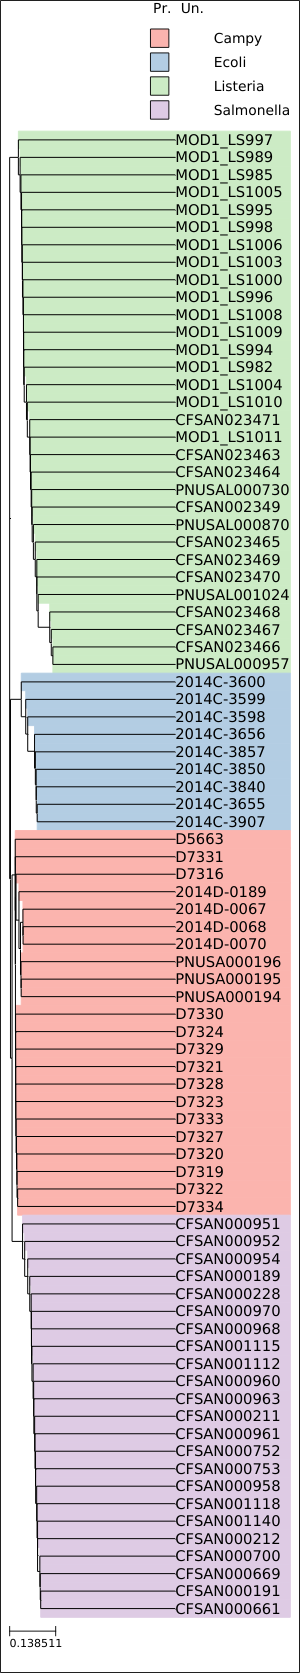

In [7]:
from ete3 import NodeStyle

node_style = NodeStyle()
node_style['size'] = 3

qkmer.tree_styler(node_style=node_style)\
 .highlight(q_campy, legend_label='Campy')\
 .highlight(q_ecoli, legend_label='Ecoli')\
 .highlight(q_listeria, legend_label='Listeria')\
 .highlight(q_salmonella, legend_label='Salmonella')\
 .render(w=300, ladderize=True)

In [8]:
from genomics_data_index.api.query.impl.ClusterScorer import ClusterScorer

min_samples_cluster = 2

scorer = ClusterScorer(qkmer)
scores_organism = scorer.score_groupby(groupby_column='dataSetName', min_samples_count=min_samples_cluster)
scores_organism

,Score,Sample Count
dataSetName,,
0810PADBR-1,1.0,22
1203NYJAP-1 - Tuna Scrape Outbreak,1.0,23
1405WAEXK-1,1.0,9
1408MLGX6-3WGS,1.0,31


In [9]:
scores_outbreak = scorer.score_groupby(groupby_column='cluster', min_samples_count=min_samples_cluster)
scores_outbreak

,Score,Sample Count
cluster,,
0810PADBR-1,0.666667,14
1203NYJAP-1,0.782609,18
1405WAEXK-1,0.333333,3
1408MLGX6-3WGS,0.903226,28
outgroup_0810PADBR-1,0.363636,8
outgroup_1203NYJAP-1 - Tuna Scrape Outbreak,0.250000,5
outgroup_1405WAEXK-1,1.000000,6
outgroup_1408MLGX6-3WGS,0.272727,3


# ML Tree

In [10]:
metadata_df['dataSetName'].value_counts().index.tolist()

['1408MLGX6-3WGS',
 '1203NYJAP-1 - Tuna Scrape Outbreak',
 '0810PADBR-1',
 '1405WAEXK-1']

In [11]:
from ete3 import NodeStyle

def ml_tree(dataset_name: str):
    reference_list = metadata_df[metadata_df['dataSetName'] == dataset_name]['reference'].value_counts().index.tolist()
    if len(reference_list) != 1:
        raise Exception(f'Incorrect number of references for {dataset_name}: {reference_list}')
    reference_name = reference_list[0]
    
    t = db.samples_query(reference_name=reference_name, universe='mutations')\
          .set_outgroup(reference_name)\
          .join(metadata_df, sample_names_column='strain')
    
    cluster_names = metadata_df[metadata_df['dataSetName'] == dataset_name]['outbreak'].value_counts().index.tolist()
    
    node_style = NodeStyle()
    node_style['size'] = 3
        
    ts = t.tree_styler(node_style=node_style)
    
    for cluster in cluster_names:
        ts = ts.highlight(t.isa(cluster, isa_column='outbreak', kind='dataframe'), legend_label=cluster)
    
    return ts

ml_tree('1405WAEXK-1')

In [12]:
t = db.samples_query(reference_name='GCA_001879185.2_ASM187918v2_genomic', universe='mutations')\
      .set_outgroup('GCA_001879185.2_ASM187918v2_genomic')\
      .join(metadata_df, sample_names_column='strain')
t

<MutationTreeSamplesQuery[selected=100% (22/22) samples, unknown=0% (0/22) samples]>

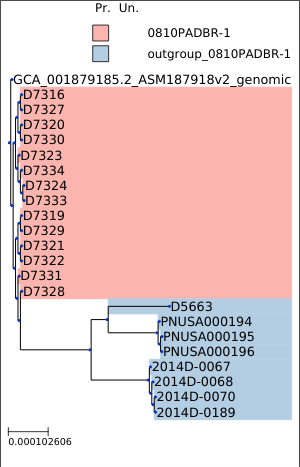

In [13]:
from ete3 import NodeStyle

node_style = NodeStyle()
node_style['size'] = 3

x = t.tree_styler(node_style=node_style)\
 .highlight(t.isa('0810PADBR-1', isa_column='outbreak', kind='dataframe'), legend_label='0810PADBR-1')\
 .highlight(t.isa('outgroup_0810PADBR-1', isa_column='outbreak', kind='dataframe'), legend_label='outgroup_0810PADBR-1')\
 .render(w=300, ladderize=True)
x

In [14]:
scorer_ml = ClusterScorer(t)
scores_outbreak = scorer_ml.score_groupby(groupby_column='cluster', min_samples_count=min_samples_cluster)
scores_outbreak

,Score,Sample Count
cluster,,
0810PADBR-1,0.636364,14
outgroup_0810PADBR-1,1.000000,8


In [15]:
t.isa('0810PADBR-1', isa_column='outbreak', kind='dataframe').features_summary(selection='unique').sort_values('Count', ascending=False)

,Sequence,Position,Deletion,Insertion,Type,Count,Unknown Count,Present and Unknown Count,Total,Percent,...,Gene_Name,Gene_ID,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p
Mutation,,,,,,,,,,,,,,,,,,,,,
CP069124.1:1190591:A:AC,CP069124.1,1190591,A,AC,INDEL,14,<NA>,<NA>,14,100.000000,...,A0X86_006255,A0X86_006255,transcript,protein_coding,c.306dupG,p.Y103fs,hgvs:CP069124.1:A0X86_006255:c.306dupG,hgvs:CP069124.1:A0X86_006255:p.Y103fs,hgvs_gn:CP069124.1:A0X86_006255:c.306dupG,hgvs_gn:CP069124.1:A0X86_006255:p.Y103fs
CP069124.1:1376739:T:TG,CP069124.1,1376739,T,TG,INDEL,11,<NA>,<NA>,14,78.571429,...,A0X86_007190,A0X86_007190,transcript,protein_coding,c.134dupG,p.I46fs,hgvs:CP069124.1:A0X86_007190:c.134dupG,hgvs:CP069124.1:A0X86_007190:p.I46fs,hgvs_gn:CP069124.1:A0X86_007190:c.134dupG,hgvs_gn:CP069124.1:A0X86_007190:p.I46fs
CP069124.1:1364330:T:TG,CP069124.1,1364330,T,TG,INDEL,9,<NA>,<NA>,14,64.285714,...,A0X86_007130,A0X86_007130,transcript,protein_coding,c.673dupG,p.D225fs,hgvs:CP069124.1:A0X86_007130:c.673dupG,hgvs:CP069124.1:A0X86_007130:p.D225fs,hgvs_gn:CP069124.1:A0X86_007130:c.673dupG,hgvs_gn:CP069124.1:A0X86_007130:p.D225fs
CP069124.1:741372:A:AG,CP069124.1,741372,A,AG,INDEL,6,<NA>,<NA>,14,42.857143,...,kdpB,A0X86_003980,transcript,protein_coding,c.807dupG,p.L270fs,hgvs:CP069124.1:A0X86_003980:c.807dupG,hgvs:CP069124.1:A0X86_003980:p.L270fs,hgvs_gn:CP069124.1:kdpB:c.807dupG,hgvs_gn:CP069124.1:kdpB:p.L270fs
CP069124.1:807524:TC:T,CP069124.1,807524,TC,T,INDEL,1,<NA>,<NA>,14,7.142857,...,hisA,A0X86_000005,transcript,protein_coding,c.350+807175delC,<NA>,hgvs:CP069124.1:A0X86_000005:c.350+807175delC,<NA>,hgvs_gn:CP069124.1:hisA:c.350+807175delC,<NA>
CP069124.1:1365317:T:TGG,CP069124.1,1365317,T,TGG,INDEL,1,<NA>,<NA>,14,7.142857,...,A0X86_007135,A0X86_007135,transcript,protein_coding,c.961_962dupGG,p.S322fs,hgvs:CP069124.1:A0X86_007135:c.961_962dupGG,hgvs:CP069124.1:A0X86_007135:p.S322fs,hgvs_gn:CP069124.1:A0X86_007135:c.961_962dupGG,hgvs_gn:CP069124.1:A0X86_007135:p.S322fs
CP069124.1:1369265:C:T,CP069124.1,1369265,C,T,SNP,1,<NA>,<NA>,14,7.142857,...,legG,A0X86_007155,transcript,protein_coding,c.1058C>T,p.P353L,hgvs:CP069124.1:A0X86_007155:c.1058C>T,hgvs:CP069124.1:A0X86_007155:p.P353L,hgvs_gn:CP069124.1:legG:c.1058C>T,hgvs_gn:CP069124.1:legG:p.P353L
CP069124.1:1348343:A:AC,CP069124.1,1348343,A,AC,INDEL,1,<NA>,<NA>,14,7.142857,...,A0X86_007050,A0X86_007050,transcript,protein_coding,c.585dupG,p.S196fs,hgvs:CP069124.1:A0X86_007050:c.585dupG,hgvs:CP069124.1:A0X86_007050:p.S196fs,hgvs_gn:CP069124.1:A0X86_007050:c.585dupG,hgvs_gn:CP069124.1:A0X86_007050:p.S196fs


In [16]:
df = t.isa('D7331').features_summary()
# df[df['Type'] != 'INDEL']
df

,Sequence,Position,Deletion,Insertion,Type,Count,Unknown Count,Present and Unknown Count,Total,Percent,...,Gene_Name,Gene_ID,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p
Mutation,,,,,,,,,,,,,,,,,,,,,
CP069124.1:1285474:C:CT,CP069124.1,1285474,C,CT,INDEL,1,<NA>,<NA>,1,100.0,...,A0X86_006745,A0X86_006745,transcript,protein_coding,c.778dupA,p.R260fs,hgvs:CP069124.1:A0X86_006745:c.778dupA,hgvs:CP069124.1:A0X86_006745:p.R260fs,hgvs_gn:CP069124.1:A0X86_006745:c.778dupA,hgvs_gn:CP069124.1:A0X86_006745:p.R260fs
CP069124.1:1486996:C:CT,CP069124.1,1486996,C,CT,INDEL,1,<NA>,<NA>,1,100.0,...,A0X86_007670,A0X86_007670,transcript,protein_coding,c.453dupA,p.E152fs,hgvs:CP069124.1:A0X86_007670:c.453dupA,hgvs:CP069124.1:A0X86_007670:p.E152fs,hgvs_gn:CP069124.1:A0X86_007670:c.453dupA,hgvs_gn:CP069124.1:A0X86_007670:p.E152fs
CP069124.1:903774:A:AT,CP069124.1,903774,A,AT,INDEL,1,<NA>,<NA>,1,100.0,...,A0X86_004785,A0X86_004785,transcript,protein_coding,c.1037dupA,p.N346fs,hgvs:CP069124.1:A0X86_004785:c.1037dupA,hgvs:CP069124.1:A0X86_004785:p.N346fs,hgvs_gn:CP069124.1:A0X86_004785:c.1037dupA,hgvs_gn:CP069124.1:A0X86_004785:p.N346fs
CP069124.1:896670:A:AT,CP069124.1,896670,A,AT,INDEL,1,<NA>,<NA>,1,100.0,...,A0X86_004740,A0X86_004740,transcript,protein_coding,c.347dupT,p.L116fs,hgvs:CP069124.1:A0X86_004740:c.347dupT,hgvs:CP069124.1:A0X86_004740:p.L116fs,hgvs_gn:CP069124.1:A0X86_004740:c.347dupT,hgvs_gn:CP069124.1:A0X86_004740:p.L116fs
CP069124.1:164859:T:TA,CP069124.1,164859,T,TA,INDEL,1,<NA>,<NA>,1,100.0,...,A0X86_000875,A0X86_000875,transcript,protein_coding,c.563dupT,p.L188fs,hgvs:CP069124.1:A0X86_000875:c.563dupT,hgvs:CP069124.1:A0X86_000875:p.L188fs,hgvs_gn:CP069124.1:A0X86_000875:c.563dupT,hgvs_gn:CP069124.1:A0X86_000875:p.L188fs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CP069124.1:1261679:T:TA,CP069124.1,1261679,T,TA,INDEL,1,<NA>,<NA>,1,100.0,...,hisA,A0X86_000005,transcript,protein_coding,c.351-372830_351-372829insA,<NA>,hgvs:CP069124.1:A0X86_000005:c.351-372830_351-...,<NA>,hgvs_gn:CP069124.1:hisA:c.351-372830_351-37282...,<NA>
CP069124.1:853537:C:CT,CP069124.1,853537,C,CT,INDEL,1,<NA>,<NA>,1,100.0,...,A0X86_004525,A0X86_004525,transcript,protein_coding,c.507dupA,p.E170fs,hgvs:CP069124.1:A0X86_004525:c.507dupA,hgvs:CP069124.1:A0X86_004525:p.E170fs,hgvs_gn:CP069124.1:A0X86_004525:c.507dupA,hgvs_gn:CP069124.1:A0X86_004525:p.E170fs
CP069124.1:734051:C:CT,CP069124.1,734051,C,CT,INDEL,1,<NA>,<NA>,1,100.0,...,A0X86_003940,A0X86_003940,transcript,protein_coding,c.155dupA,p.P53fs,hgvs:CP069124.1:A0X86_003940:c.155dupA,hgvs:CP069124.1:A0X86_003940:p.P53fs,hgvs_gn:CP069124.1:A0X86_003940:c.155dupA,hgvs_gn:CP069124.1:A0X86_003940:p.P53fs


In [17]:
t.isa('outgroup_0810PADBR-1', isa_column='outbreak', kind='dataframe').features_summary(selection='unique').sort_values('Count', ascending=False)

,Sequence,Position,Deletion,Insertion,Type,Count,Unknown Count,Present and Unknown Count,Total,Percent,...,Gene_Name,Gene_ID,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,ID_HGVS.c,ID_HGVS.p,ID_HGVS_GN.c,ID_HGVS_GN.p
Mutation,,,,,,,,,,,,,,,,,,,,,
CP069124.1:198888:C:T,CP069124.1,198888,C,T,SNP,8,<NA>,<NA>,8,100.0,...,cdtA,A0X86_001075,transcript,protein_coding,c.396G>A,p.A132A,hgvs:CP069124.1:A0X86_001075:c.396G>A,hgvs:CP069124.1:A0X86_001075:p.A132A,hgvs_gn:CP069124.1:cdtA:c.396G>A,hgvs_gn:CP069124.1:cdtA:p.A132A
CP069124.1:206372:A:G,CP069124.1,206372,A,G,SNP,8,<NA>,<NA>,8,100.0,...,A0X86_001110,A0X86_001110,transcript,protein_coding,c.660A>G,p.L220L,hgvs:CP069124.1:A0X86_001110:c.660A>G,hgvs:CP069124.1:A0X86_001110:p.L220L,hgvs_gn:CP069124.1:A0X86_001110:c.660A>G,hgvs_gn:CP069124.1:A0X86_001110:p.L220L
CP069124.1:198723:G:A,CP069124.1,198723,G,A,SNP,8,<NA>,<NA>,8,100.0,...,cdtA,A0X86_001075,transcript,protein_coding,c.561C>T,p.C187C,hgvs:CP069124.1:A0X86_001075:c.561C>T,hgvs:CP069124.1:A0X86_001075:p.C187C,hgvs_gn:CP069124.1:cdtA:c.561C>T,hgvs_gn:CP069124.1:cdtA:p.C187C
CP069124.1:1131867:T:C,CP069124.1,1131867,T,C,SNP,8,<NA>,<NA>,8,100.0,...,A0X86_005975,A0X86_005975,transcript,protein_coding,c.1317A>G,p.K439K,hgvs:CP069124.1:A0X86_005975:c.1317A>G,hgvs:CP069124.1:A0X86_005975:p.K439K,hgvs_gn:CP069124.1:A0X86_005975:c.1317A>G,hgvs_gn:CP069124.1:A0X86_005975:p.K439K
CP069124.1:204436:A:G,CP069124.1,204436,A,G,SNP,8,<NA>,<NA>,8,100.0,...,aspA,A0X86_001105,transcript,protein_coding,c.147A>G,p.L49L,hgvs:CP069124.1:A0X86_001105:c.147A>G,hgvs:CP069124.1:A0X86_001105:p.L49L,hgvs_gn:CP069124.1:aspA:c.147A>G,hgvs_gn:CP069124.1:aspA:p.L49L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CP069124.1:304494:C:A,CP069124.1,304494,C,A,SNP,1,<NA>,<NA>,8,12.5,...,hisA,A0X86_000005,transcript,protein_coding,c.350+304144C>A,<NA>,hgvs:CP069124.1:A0X86_000005:c.350+304144C>A,<NA>,hgvs_gn:CP069124.1:hisA:c.350+304144C>A,<NA>
CP069124.1:304850:G:A,CP069124.1,304850,G,A,SNP,1,<NA>,<NA>,8,12.5,...,A0X86_001670,A0X86_001670,transcript,protein_coding,c.81G>A,p.P27P,hgvs:CP069124.1:A0X86_001670:c.81G>A,hgvs:CP069124.1:A0X86_001670:p.P27P,hgvs_gn:CP069124.1:A0X86_001670:c.81G>A,hgvs_gn:CP069124.1:A0X86_001670:p.P27P
CP069124.1:300233:T:C,CP069124.1,300233,T,C,SNP,1,<NA>,<NA>,8,12.5,...,A0X86_001645,A0X86_001645,transcript,protein_coding,c.639A>G,p.G213G,hgvs:CP069124.1:A0X86_001645:c.639A>G,hgvs:CP069124.1:A0X86_001645:p.G213G,hgvs_gn:CP069124.1:A0X86_001645:c.639A>G,hgvs_gn:CP069124.1:A0X86_001645:p.G213G
